In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:

# 1. Cargar los datos
train_features = pd.read_csv('../data/raw/training_set_features.csv')
train_labels = pd.read_csv('../data/raw/training_set_labels.csv')



In [9]:

# Combinar features y labels para el análisis
train_data = pd.merge(train_features, train_labels, on='respondent_id')

# 2. Exploración de Datos
print(f"Dimensiones del conjunto de datos: {train_data.shape}")
print("\nDistribución de las variables objetivo:")
print(f"h1n1_vaccine:\n{train_data['h1n1_vaccine'].value_counts(normalize=True)}")
print(f"seasonal_vaccine:\n{train_data['seasonal_vaccine'].value_counts(normalize=True)}")

# Verificar valores faltantes
missing_values = train_data.isnull().sum()
print("\nValores faltantes por columna:")
print(missing_values[missing_values > 0])


Dimensiones del conjunto de datos: (26707, 38)

Distribución de las variables objetivo:
h1n1_vaccine:
h1n1_vaccine
0    0.787546
1    0.212454
Name: proportion, dtype: float64
seasonal_vaccine:
seasonal_vaccine
0    0.534392
1    0.465608
Name: proportion, dtype: float64

Valores faltantes por columna:
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective   

In [10]:

# 3. Preprocesamiento
# Separar las características y los objetivos
X = train_data.drop(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y_h1n1 = train_data['h1n1_vaccine']
y_seasonal = train_data['seasonal_vaccine']

# Identificar tipos de columnas
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# 3.1 Estrategia de preprocesamiento
# Para columnas numéricas: Imputación de valores faltantes + Escalado
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Para columnas categóricas: Imputación + One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [11]:

# 4. División de datos: entrenamiento y validación
X_train, X_test, y_h1n1_train, y_h1n1_test, y_seasonal_train, y_seasonal_test = train_test_split(
    X, y_h1n1, y_seasonal, test_size=0.2, random_state=42, stratify=y_h1n1
)


In [12]:

# 5. Optimización de hiperparámetros para XGBoost
# 5.1 Definir el pipeline base para XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', random_state=42))
])

# 5.2 Definir los parámetros a optimizar
param_grid = {
    'classifier__learning_rate': [0.1],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__min_child_weight': [1, 5],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]

}

# 5.3 Optimización para el modelo H1N1
print("\nRealizando búsqueda de hiperparámetros para H1N1...")
h1n1_gs = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,  # Usar validación cruzada de 3 pliegues para mayor velocidad
    verbose=1,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

h1n1_gs.fit(X_train, y_h1n1_train)

print(f"\nMejores parámetros para H1N1: {h1n1_gs.best_params_}")
print(f"Mejor AUC para H1N1: {h1n1_gs.best_score_:.4f}")

# 5.4 Optimización para el modelo Seasonal
print("\nRealizando búsqueda de hiperparámetros para Seasonal...")
seasonal_gs = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

seasonal_gs.fit(X_train, y_seasonal_train)

print(f"\nMejores parámetros para Seasonal: {seasonal_gs.best_params_}")
print(f"Mejor AUC para Seasonal: {seasonal_gs.best_score_:.4f}")



Realizando búsqueda de hiperparámetros para H1N1...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Mejores parámetros para H1N1: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Mejor AUC para H1N1: 0.8407

Realizando búsqueda de hiperparámetros para Seasonal...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Mejores parámetros para Seasonal: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Mejor AUC para Seasonal: 0.8591


In [13]:

# 6. Crear modelos finales con los mejores parámetros
# 6.1 Modelo H1N1 optimizado
final_h1n1_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=len(y_h1n1_train) / sum(y_h1n1_train) - 1,  # Manejo del desbalance
        random_state=42,
        **{k.replace('classifier__', ''): v for k, v in h1n1_gs.best_params_.items()}
    ))
])

# 6.2 Modelo Seasonal optimizado
final_seasonal_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=len(y_seasonal_train) / sum(y_seasonal_train) - 1,  # Manejo del desbalance
        random_state=42,
        **{k.replace('classifier__', ''): v for k, v in seasonal_gs.best_params_.items()}
    ))
])


In [14]:

# 7. Evaluar modelos optimizados en el conjunto de prueba
final_h1n1_model.fit(X_train, y_h1n1_train)
final_seasonal_model.fit(X_train, y_seasonal_train)

# Evaluación para H1N1
h1n1_probs = final_h1n1_model.predict_proba(X_test)[:, 1]
h1n1_auc = roc_auc_score(y_h1n1_test, h1n1_probs)
print(f"\nAUC en test para H1N1 (modelo optimizado): {h1n1_auc:.4f}")

# Evaluación para Seasonal
seasonal_probs = final_seasonal_model.predict_proba(X_test)[:, 1]
seasonal_auc = roc_auc_score(y_seasonal_test, seasonal_probs)
print(f"AUC en test para Seasonal (modelo optimizado): {seasonal_auc:.4f}")



AUC en test para H1N1 (modelo optimizado): 0.8346
AUC en test para Seasonal (modelo optimizado): 0.8615


In [15]:

# 8. Entrenar modelos finales con todos los datos
print("\nEntrenando modelos finales con todos los datos...")
final_h1n1_model.fit(X, y_h1n1)
final_seasonal_model.fit(X, y_seasonal)



Entrenando modelos finales con todos los datos...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   '...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])


Características más importantes para predicción de vacuna H1N1:
                           feature  importance
9                 doctor_recc_h1n1    0.310928
15     opinion_h1n1_vacc_effective    0.044180
16               opinion_h1n1_risk    0.043025
13                   health_worker    0.025163
84  employment_occupation_cmhcxjea    0.022333
19               opinion_seas_risk    0.020701
85  employment_occupation_dcjcmpih    0.016458
66    employment_industry_haxffmxo    0.015160
10            doctor_recc_seasonal    0.014688
65    employment_industry_fcxhlnwr    0.010416

Características más importantes para predicción de vacuna Seasonal:
                           feature  importance
10            doctor_recc_seasonal    0.168788
18     opinion_seas_vacc_effective    0.084391
19               opinion_seas_risk    0.066234
27             age_group_65+ Years    0.049304
23         age_group_18 - 34 Years    0.031363
13                   health_worker    0.025425
85  employment_occup

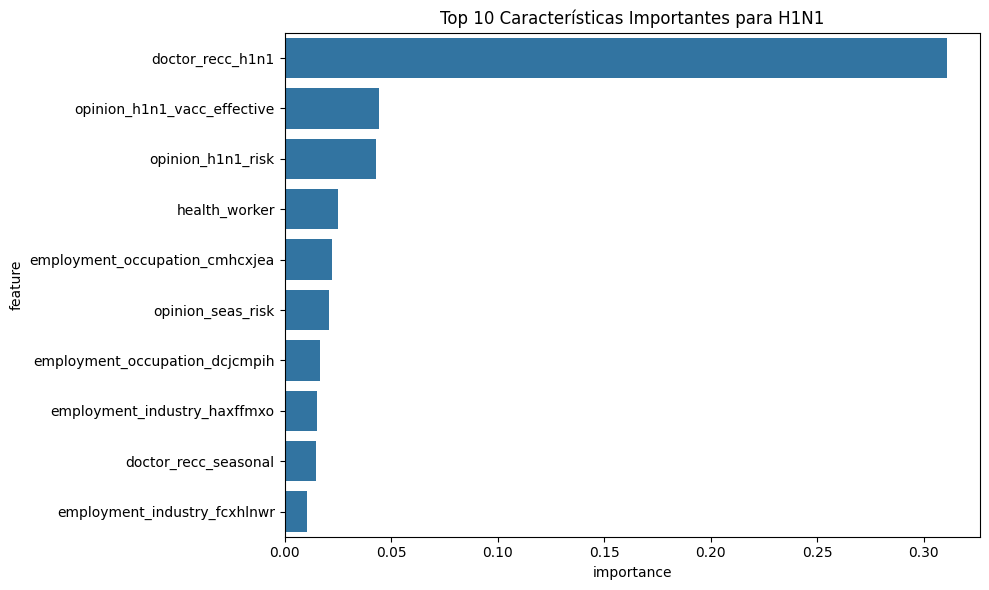

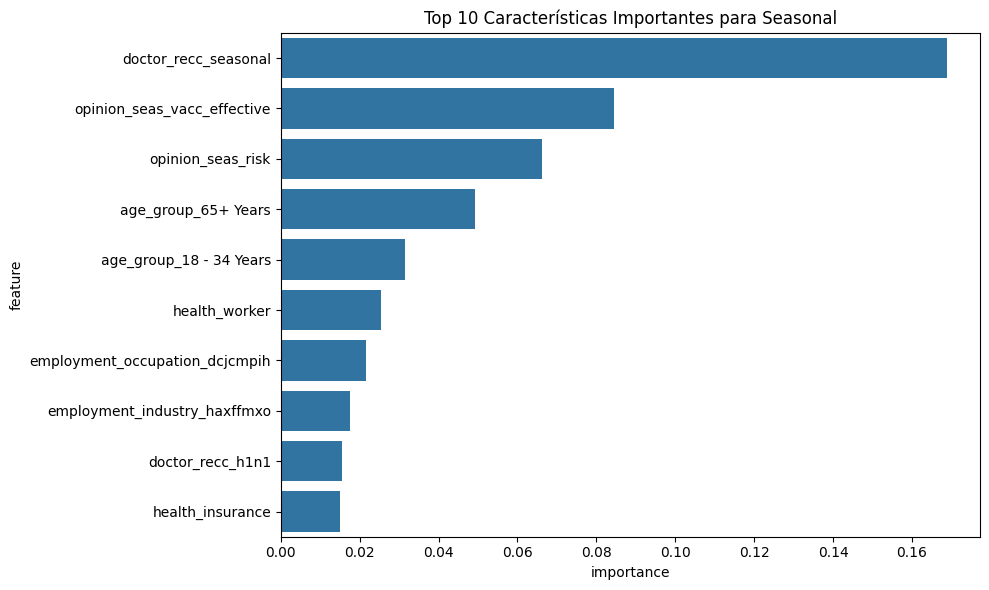

In [16]:

# 9. Análisis de características importantes (para XGBoost)
# Primero aplicamos el preprocesador a todos los datos para obtener las características transformadas
X_processed = preprocessor.fit_transform(X)
feature_names = (
    numeric_cols +
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))
)

# Obtener importancia de características para H1N1
h1n1_importance = final_h1n1_model.named_steps['classifier'].feature_importances_
h1n1_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': h1n1_importance
}).sort_values('importance', ascending=False)

print("\nCaracterísticas más importantes para predicción de vacuna H1N1:")
print(h1n1_importance_df.head(10))

# Visualizar importancia de características para H1N1
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=h1n1_importance_df.head(10))
plt.title('Top 10 Características Importantes para H1N1')
plt.tight_layout()
plt.savefig('h1n1_feature_importance.png')

# Obtener importancia de características para Seasonal
seasonal_importance = final_seasonal_model.named_steps['classifier'].feature_importances_
seasonal_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': seasonal_importance
}).sort_values('importance', ascending=False)

print("\nCaracterísticas más importantes para predicción de vacuna Seasonal:")
print(seasonal_importance_df.head(10))

# Visualizar importancia de características para Seasonal
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=seasonal_importance_df.head(10))
plt.title('Top 10 Características Importantes para Seasonal')
plt.tight_layout()
plt.savefig('seasonal_feature_importance.png')


In [ ]:

# 10. Predicciones para el conjunto de prueba (si existiera)
test_features = pd.read_csv('../data/raw/test_set_features.csv')
   
   # Realizar predicciones
h1n1_preds = final_h1n1_model.predict_proba(test_features.drop('respondent_id', axis=1))[:, 1]
seasonal_preds = final_seasonal_model.predict_proba(test_features.drop('respondent_id', axis=1))[:, 1]
    
    # Preparar el formato de envío
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'h1n1_vaccine': h1n1_preds,
    'seasonal_vaccine': seasonal_preds
})
    
submission.to_csv('submission.csv', index=False)
print("\nArchivo de envío 'submission.csv' creado correctamente.")




Archivo de envío 'submission.csv' creado correctamente.


In [18]:

# 11. Evaluación del rendimiento con validación cruzada
print("\nEvaluación de modelos optimizados con validación cruzada:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluación para H1N1
h1n1_cv_scores = cross_val_score(final_h1n1_model, X, y_h1n1, cv=cv, scoring='roc_auc')
print(f"XGBoost optimizado AUC H1N1: {h1n1_cv_scores.mean():.4f} ± {h1n1_cv_scores.std():.4f}")

# Evaluación para Seasonal
seasonal_cv_scores = cross_val_score(final_seasonal_model, X, y_seasonal, cv=cv, scoring='roc_auc')
print(f"XGBoost optimizado AUC Seasonal: {seasonal_cv_scores.mean():.4f} ± {seasonal_cv_scores.std():.4f}")

print("\n¡Optimización completada con éxito!")


Evaluación de modelos optimizados con validación cruzada:
XGBoost optimizado AUC H1N1: 0.8403 ± 0.0054
XGBoost optimizado AUC Seasonal: 0.8615 ± 0.0033

¡Optimización completada con éxito!
